# MS-E2122 - Nonlinear Optimization
Prof. Fabricio Oliveira

## Project Assignment 2 - ADMM

In [1]:
using JuMP
using Ipopt
using Random
using Test
using LinearAlgebra
using Plots
#pyplot()

The code below generates the structure used to create and give instances as input to the routines we will implement later.

In [2]:
struct Instance
    I  # Supplier index set
    J  # Client index set
    S  # Scenario index set
    C  # Unit capacity costs of suppliers
    D  # Client demands in all scenarios
    Q  # Unit costs of unfulfilled demand
    P  # Scenario probabilities
    F  # Unit costs to fulfil demands
    Bs # Max supplier capacities
    Bc # Max budget (cost) for capacity acquisition
end

function generate_instance(nI, nJ, nS)
    Random.seed!(1)
    I = 1:nI                          # Supplier index set
    J = 1:nJ                          # Client index set
    S = 1:nS                          # Scenario index set
    C = rand(5:20, nI)                # Unit capacity costs of suppliers
    D = rand(nJ,nS).*rand(5:40, nJ)   # Client demands in all scenarios
    Q = rand(4000:90000, nJ)          # Unit costs of unfulfilled demand
    P = ones(nS).*1/nS                # Scenario probabilities
    F = rand(2:30, (nI,nJ))           # Unit costs to fulfil demands
    Bs = rand(10:80, nI)              # Max supplier capacities
    Bc = 1500                         # Max budget (cost) for capacity acquisition

    Instance(I, J, S, C, D, Q, P, F, Bs, Bc)
end

function unpack_instance(instance)
    return (instance.I, 
            instance.J, 
            instance.S, 
            instance.C, 
            instance.D, 
            instance.Q, 
            instance.P, 
            instance.F, 
            instance.Bs, 
            instance.Bc
            )
end

function print_solution_stats(x, C)
    # Print capacity cost.
    fval = dot(C, value.(x))   # Optimal cost of reserved capacities                        
    println("Optimal cost of reserved capacities: ", fval)

    # Print optimal solution 
    println("Optimal solution:")
    for i = 1:length(x)
        println("x[$i] = ", round(value(x[i]),digits=2))
    end
end

print_solution_stats (generic function with 1 method)

Here is the implementaiton of the stochastic capacity expansion problem as described. You can use this as reference for benchmarking the correctness and the performance of your model.

In [3]:
# Function to solve an instance of the full-scale model
function full_scale_model(instance; log=false)
    
    # Unpacking instance information
    (I, J, S, C, D, Q, P, F, Bs, Bc) = unpack_instance(instance)

    # We first solve the problem formulation directly without ADMM
    model = Model(Ipopt.Optimizer)                      # We use Ipopt solver to compare with ADMM                                                       

    # Variables
    @variable(model, x[i in I] >= 0)                    # Reserved capacity variables
    @variable(model, y[i in I, j in J, s in S] >= 0)    # Demand fulfilment variables
    @variable(model, u[j in J, s in S] >= 0)            # Unfulfilled demand variables

    # Objective: Minimize the total phase 1 + phase 2 costs over all scenarios
    @objective(model, Min,
          sum(C[i]*x[i] for i in I) +
          sum(P[s]*F[i,j]*y[i,j,s] for s in S, i in I, j in J) + 
          sum(P[s]*Q[j]*u[j,s] for s in S, j in J))

    # Constraints
    @constraint(model, [i in I], x[i] <= Bs[i])          # Max capacity constraint
    @constraint(model, sum(C[i]*x[i] for i in I) <= Bc)  # Max capacity budget (cost) constraint

    # Capacity reserve limit constraint for each supplier i in each scenario s
    @constraint(model, [i in I, s in S], sum(y[i,j,s] for j in J) <= x[i])

    # Demand balance constraint (u[j,s] is unfulfilled demand of client j in scenario s)
    @constraint(model, DemBal[j in J, s in S], sum(y[i,j,s] for i in I) + u[j,s] == D[j,s])
 
    if !log
        set_silent(model)    # Solve the problem
    end
    
    optimize!(model)         # Solve the problem
    
    print_solution_stats(x, C)
    return value.(x) 
    
end

full_scale_model (generic function with 1 method)

We can then generate one "test" instance that will serve as reference for us.

In [4]:
Random.seed!(1)
@time test_instance = generate_instance(15,20,10);

  0.000310 seconds (20 allocations: 7.875 KiB)


To time these functions, we will use the `@time` macro since the operation takes several seconds and doing multiple replications would be time consuming. Notice however that Julia uses JIT compilation, so the first time the function is run, it is also compiled. To discount this time from the timing, you cansimply remove the percentage associated with compilation time. 

Of course, once you ran the function on this test instance, it will have been compiled and you don't need then to worry about compilation times when considering the actual instances later.

In [5]:
@time x_full = full_scale_model(test_instance);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Optimal cost of reserved capacities: 1500.000016388812
Optimal solution:
x[1] = 36.0
x[2] = 0.8
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 25.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 61.0
x[11] = 0.0
x[12] = 0.0
x[13] = 46.0
x[14] = 47.0
x[15] = 0.0
 18.152807 seconds (44.75 M allocations: 2.387 GiB, 4.55% gc time, 94.23% compilation time)


## ADMM implementation

Next we will implement the function that employs ADMM to solve the stochastic capacity expansion problem. Notice you are required to implement:
1. The objective function of the augmented Lagrangian form
2. The combined primal and dual residual
3. The z-update
4. The dual update.

The input of the function is an `Instance` struct. The output is the value of the JuMP variable `x_s` and the number of iterations `k`.

In [6]:
function admm_model(instance; ρ=1.0, N=200, ϵ=1e-1)   
    
    # Unpacking instance information
    (I, J, S, C, D, Q, P, F, Bs, Bc) = unpack_instance(instance)
    nI = length(I) 
    nJ = length(J)
    nS = length(S)

    # NOTE: ADMM approach starts from here. Complete the missing code parts that
    #       are requested. NOTE: Use Exercise 10.1 as a reference.

    # Problem parameters and memory allocation. NOTE: Compare with Exercise 10.1
    x_s  = zeros(nI, nS)  # Store each x vector in (x,y)-steps of each scenario
    v_s  = zeros(nI, nS)  # Store each v vector in v-steps of each scenario
    z    = zeros(nI)      # Store z vectors at each ADNM iteration
    
    # Main loop
    for k = 1:N
        # Loop for solving each (x,y) step separately for each scenario s in S.
        for s in S   

            # Model to solve (x,y)-step of the current scenario subproblem s
            scen_m = Model(optimizer_with_attributes(Ipopt.Optimizer))
            
            @variable(scen_m, x[i in I] >= 0)                    # Reserved capacity variables
            @variable(scen_m, y[i in I, j in J] >= 0)            # Demand fulfilment variables
            @variable(scen_m, u[j in J] >= 0)                    # Unfulfilled demand variables

            @constraint(scen_m, [i in I], x[i] <= Bs[i])          # Max capacity constraint
            @constraint(scen_m, sum(C[i]*x[i] for i in I) <= Bc)  # Max capacity budget (cost)
            
            # Capacity reserve limit constraint for each supplier i
            @constraint(scen_m, [i in I], sum(y[i,j] for j in J) <= x[i])
            
            # Demand balance constraint (u[j] is unfulfilled demand of client j)
            @constraint(scen_m, [j in J], sum(y[i,j] for i in I) == D[j,s] - u[j])

            # TODO: Complete this objective to compute (x,y)-step for the
            #       current scenario. 
            @objective(scen_m, Min, 
                sum((C[i]+v_s[i,s])*x[i] for i in I) +
                sum(F[i,j]*y[i,j] for i in I, j in J) + 
                sum(Q[j]*u[j] for j in J) + 
                sum((ρ/2)*(x[i]-z[i])^2 for i in I)
            )

            # Solve the (x,y) step for the current scenario
            set_silent(scen_m)
            optimize!(scen_m)

            # Store the value of x for the current scenario
            x_s[:,s] = value.(x[:])
        end

        # Compute primal and dual residuals. We use array to exploit parallelism
        tol = zeros(nS)
        
        # TODO: Complete the computation of the residual for each s.
        for s in S
            tol[s] = P[s]*ρ*norm(x_s[:,s]-z)
        end
        
        # Total residual = sum of subproblem residuals
        tol = sum(tol[s] for s in S)

        # Print current progress
        println("iteration: $k | residual: $tol")
        # Stopping condition: if primal + dual residual is small enough
        if tol < ϵ
            print_solution_stats(sum(x_s,dims=2)./nS, C)
            return (value.(x_s), k)
        end

        # TODO: Compute z-step for this iteration
        z = sum(P[s]*x_s[:,s] for s in S)

        # TODO: Update v-step separately for each scenario
        for s in S
            v_s[:,s] = v_s[:,s] + ρ.*(x_s[:,s] - z)
        end
        
        # Check whether the iterations limit is exceeded while stopping condition isn't met
        if k == N 
            println("Algorithm terminated because of exceeding the limit of iterations($N))")
        end
    end

    print_solution_stats(sum(x_s,dims=2)./nS, tend, C)
    return (value.(x_s), k) 
end

admm_model (generic function with 1 method)

As before, let us test our implementation on a test instance. For verifying our implementation, we will compare the solution of the full scale model and the ADMM model to verify correctness.

In [7]:
@time (x_s, k) = admm_model(test_instance);

  2.852591 seconds (4.37 M allocations: 245.568 MiB, 1.90% gc time, 58.15% compilation time)


In [8]:
#=The actual solution is the average of the scenario-dependent solutions (with 10 scenarios for the test instance). Notice that they should all match is the
primal residual is sufficiently small=#
x_admm = sum(x_s, dims=2)./10;

# Test whether the solutions match, within a specific tolerance
# @test norm(x_full - x_admm) ≤ 0.1

15×1 Matrix{Float64}:
 36.00000035963648
  0.8000001439953273
  0.0
  0.0
  0.0
 25.00000024926984
  0.0
  0.0
  0.0
 61.00000060951531
  0.0
  0.0
 46.0000004585368
 47.000000469709654
  0.0

We are now ready to make comparisons considering different instances (with 50, 75 and 100 scenarios). Make sure you have executed your functions before in the test instance, so Julia JIT compiler has the function ready and you can measure only execution time. (Notice that the time macro will inform any compiling time otherwise).

Use instances below to perform your computational experiments. Use the small instances to try different values of $\rho \in [0.5 , 100]$. Some ideas for analyses include:
1. How does the value of $\rho$ influence the precision (which can be measured by `norm(x_full - x_admm)` of the final solution)?
2. What value of $\rho$ provides the fastest time (tip: you can use the macro `@elapsed` to save the time to a variable. E.g.)
```julia
t = @elapsed full_scale_model(small_instance)
print(t) # Prints out the time taken by the function, now saved on variable t.
```
3. Is ADMM faster? How does the difference between the solution times of the full scale and the ADMM models behaves as the number of scenarios increase?

In [9]:
small_instance = generate_instance(15,20,50)
medium_instance = generate_instance(15,20,75)
large_instance = generate_instance(15,20,100);

## Additional code for the Project assignment 2

Use the cells below or any additional cell you might need to write the code to generate the analytical results required.

In [10]:
@time x = full_scale_model(small_instance);
@time x = admm_model(small_instance);

Optimal cost of reserved capacities: 1500.0000163891157
Optimal solution:
x[1] = 36.0
x[2] = 0.8
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 25.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 61.0
x[11] = 0.0
x[12] = 0.0
x[13] = 46.0
x[14] = 47.0
x[15] = 0.0
 12.254176 seconds (310.80 k allocations: 28.514 MiB)
 46.803235 seconds (7.44 M allocations: 598.016 MiB, 0.27% gc time)


In [11]:
@time x = full_scale_model(medium_instance);
@time x = admm_model(medium_instance);

Optimal cost of reserved capacities: 1500.0000163895443
Optimal solution:
x[1] = 24.0
x[2] = 20.5
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 61.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 47.0
x[11] = 0.0
x[12] = 0.0
x[13] = 16.0
x[14] = 38.0
x[15] = 0.0
 25.028391 seconds (463.69 k allocations: 38.752 MiB)
 27.553888 seconds (4.19 M allocations: 336.300 MiB, 0.31% gc time)


In [12]:
@time x = full_scale_model(large_instance);
@time x = admm_model(large_instance, ρ=100.0);

Optimal cost of reserved capacities: 1500.000016389539
Optimal solution:
x[1] = 36.0
x[2] = 0.8
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 25.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 61.0
x[11] = 0.0
x[12] = 0.0
x[13] = 46.0
x[14] = 47.0
x[15] = 0.0
 34.041354 seconds (615.86 k allocations: 55.335 MiB)
222.944330 seconds (36.22 M allocations: 2.846 GiB, 0.24% gc time, 0.00% compilation time)


In [13]:
xact_small = @elapsed full_scale_model(small_instance);
xact_medium = @elapsed full_scale_model(medium_instance);
xact_large = @elapsed full_scale_model(large_instance);

Optimal cost of reserved capacities: 1500.0000163891157
Optimal solution:
x[1] = 36.0
x[2] = 0.8
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 25.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 61.0
x[11] = 0.0
x[12] = 0.0
x[13] = 46.0
x[14] = 47.0
x[15] = 0.0
Optimal cost of reserved capacities: 1500.0000163895443
Optimal solution:
x[1] = 24.0
x[2] = 20.5
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 61.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 47.0
x[11] = 0.0
x[12] = 0.0
x[13] = 16.0
x[14] = 38.0
x[15] = 0.0
Optimal cost of reserved capacities: 1500.000016389539
Optimal solution:
x[1] = 36.0
x[2] = 0.8
x[3] = 0.0
x[4] = 0.0
x[5] = 0.0
x[6] = 25.0
x[7] = 0.0
x[8] = 0.0
x[9] = 0.0
x[10] = 61.0
x[11] = 0.0
x[12] = 0.0
x[13] = 46.0
x[14] = 47.0
x[15] = 0.0


### Timing

In [68]:
rhorange = collect(1:20:101)
runtimes = zeros(length(rhorange),3)

for (i,rho) in enumerate(rhorange)
    runtimes[i,1] = @elapsed admm_model(small_instance, ρ=rho);
    runtimes[i,2] = @elapsed admm_model(medium_instance, ρ=rho);
    runtimes[i,3] = @elapsed admm_model(large_instance, ρ=rho);
    #println("iter ",i," for ρ=",rho," done")
end
#runtimes


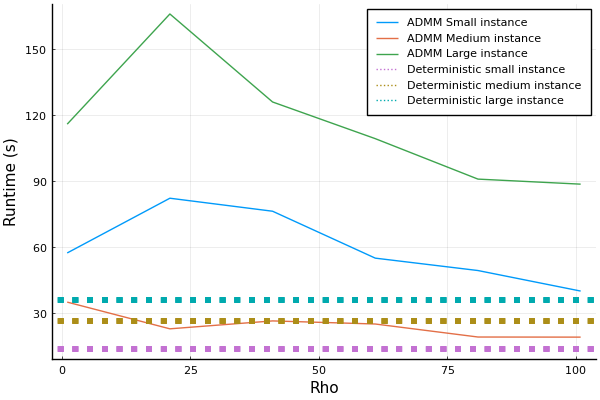

In [69]:
plot(rhorange, 
    runtimes[:,:], 
    label = ["ADMM Small instance" "ADMM Medium instance" "ADMM Large instance"],
    xlabel = "Rho",
    ylabel = "Runtime (s)"
)
hline!(rhorange,line=(:dot, 4), fill(xact_small,length(rhorange) ), label = "Deterministic small instance") 
hline!(rhorange,line=(:dot, 4), fill(xact_medium,length(rhorange)), label = "Deterministic medium instance")
hline!(rhorange,line=(:dot, 4), fill(xact_large,length(rhorange)), label = "Deterministic large instance")
#savefig("Figures/times.png")

### Iterations

In [66]:
rhorange_iterations = collect(1:1:3)
iterations = zeros(length(rhorange_iterations),3)

for (i,rho) in enumerate(rhorange_iterations)
    (⋅,iterations[i,1]) =  admm_model(small_instance, ρ=rho);
    (⋅,iterations[i,2]) =  admm_model(medium_instance, ρ=rho);
    (⋅,iterations[i,3]) =  admm_model(large_instance, ρ=rho);
    println("iter ",i," for ρ=",rho," done")
end

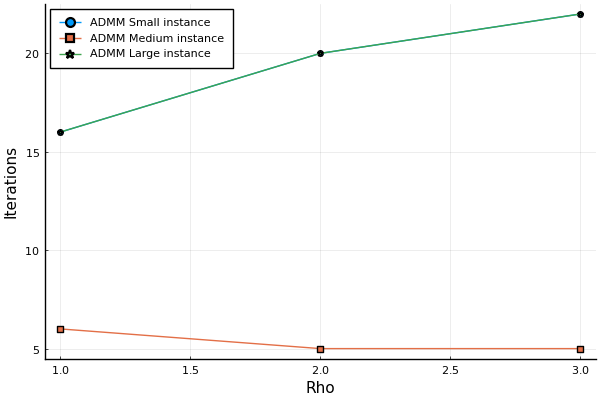

In [67]:
plot(rhorange_iterations, 
    iterations[:,:], 
    label = ["ADMM Small instance" "ADMM Medium instance" "ADMM Large instance"],
    xlabel = "Rho",
    ylabel = "Iterations",
    markershape = :auto,
    #layout = 3
)
#savefig("Figures/iterations.png")

### Combined

In [17]:
macro time_and_value(ex)
  quote
      while false; end # compiler heuristic: compile this block (alter this if the heuristic changes)
      local elapsedtime = time_ns()
      local val = $(esc(ex))
      elapsedtime = time_ns() - elapsedtime
      seconds = round(Float64(elapsedtime/1e9),digits=6)
      (seconds, val[2])
  end
end

@time_and_value (macro with 1 method)

In [18]:
rhorange = collect(0.5:20:100)
runtimes = zeros(length(rhorange),3)
iterations = zeros(length(rhorange),3)

for (i,rho) in enumerate(rhorange)
  (runtimes[i,1],iterations[i,1]) = @time_and_value admm_model(small_instance, ρ=rho);
  (runtimes[i,2],iterations[i,2]) = @time_and_value admm_model(medium_instance, ρ=rho);
  (runtimes[i,3],iterations[i,3]) = @time_and_value admm_model(large_instance, ρ=rho);
  #println("iter ",i," for ρ=",rho," done")
end
#runtimes


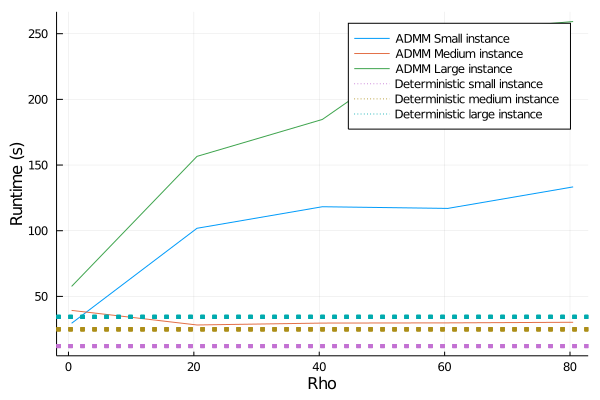

In [19]:
plot(rhorange, 
    runtimes[:,:], 
    label = ["ADMM Small instance" "ADMM Medium instance" "ADMM Large instance"],
    xlabel = "Rho",
    ylabel = "Runtime (s)"
)
hline!(rhorange,line=(:dot, 4), fill(xact_small,length(rhorange) ), label = "Deterministic small instance") 
hline!(rhorange,line=(:dot, 4), fill(xact_medium,length(rhorange)), label = "Deterministic medium instance")
hline!(rhorange,line=(:dot, 4), fill(xact_large,length(rhorange)), label = "Deterministic large instance")
#savefig("Figures/times.png")

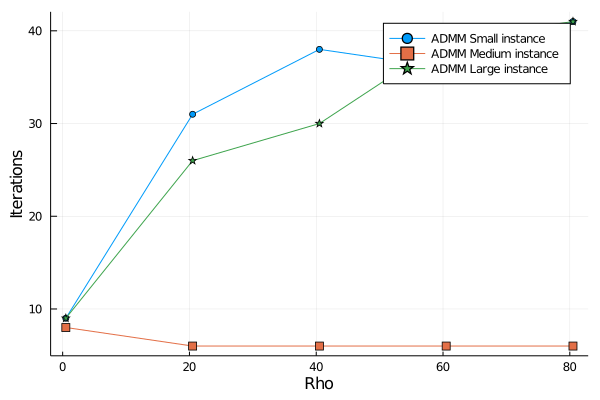

In [20]:
plot(rhorange, 
    iterations[:,:], 
    label = ["ADMM Small instance" "ADMM Medium instance" "ADMM Large instance"],
    xlabel = "Rho",
    ylabel = "Iterations",
    markershape = :auto,
    #layout = 3
)
#savefig("Figures/iterations.png")